# TP1 - Régression Linéaire : prix d'un diamant


Dataset (source : https://www.kaggle.com/datasets/shivam2503/diamonds):

* **price** : price in US dollars (\\$326-$18,823)
* **carat** : weight of the diamond (0.2-5.01)
* **cut** : quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* **color** : diamond colour, from J (worst) to D (best)
* **clarity** : a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* **x** : length in mm (0-10.74)
* **y** : width in mm (0-58.9)
* **z** : depth in mm (0-31.8)
* **depth** : total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43-79)
* **table** : width of top of diamond relative to widest point (43-95)

L'objectif est de prédire le prix d'un diamant à partir des informations que l'on a. Le notebook que l'on présente est un point de départ, et ne suffit pas à une étude de data science.

Commençons par importer les données :

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("TP1 - Diamants.csv")
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


On remarque une colonne qui ne sert à rien, supprimons-la.

In [2]:
df = df.drop(columns=["Unnamed: 0"], axis=1)
df.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


## Visualisation des données

Commençons par visualiser les données. Nous voyons que nous avons deux types :
* Numérique : *carat, depth*, ...
* Catégorielle : *cut, color*, ...

Nous devons donc avoir un travail différencié.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
%matplotlib inline



def exploratory_scatter(vector, name, alpha=0.8, figsize=(10, 5), **kwargs):
    plt.figure(figsize=figsize)
    plt.scatter(x=vector, y=df["price"], alpha=alpha, **kwargs)
    plt.xlabel(name.capitalize())
    plt.ylabel("Price")
    plt.title("Price in function of %s" % name.lower())
    plt.show()

La fonction que nous venons de définir nous permet de visualiser la relation entre un vecteur (quelconque) et la variable d'intérêt $y$. Testons-la :

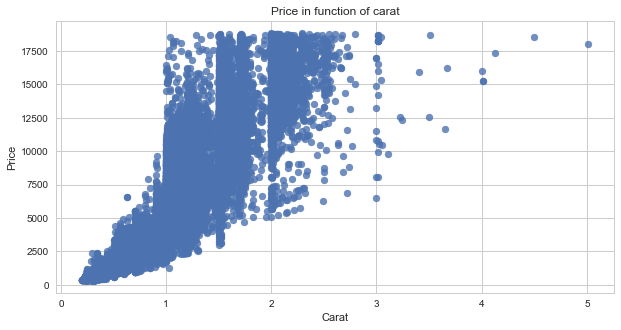

In [4]:
exploratory_scatter(df["carat"], "Carat")

Il semblerait y avoir une tendance polynomiale, vérifions :

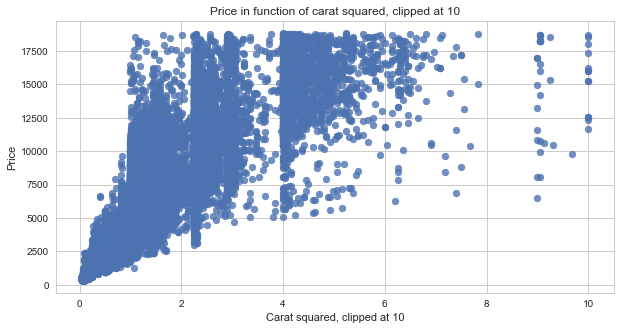

In [5]:
exploratory_scatter(np.clip(df["carat"]**2, 0, 10), "Carat squared, clipped at 10")

En mettant au carré la valeur de la variable *carat* on obtient un comportement un peu plus linéaire. Passons maintenant aux variables catégorielles.

In [6]:
def explore_categoric(column, metrics=['count', 'min', 'mean', 'max']):
    grouped = df.groupby(by=column, as_index=False).agg(metrics)
    grouped = grouped[[('price', metric) for metric in metrics]]
    for column in grouped.columns:
        grouped[column] = grouped[column].apply(lambda x: round(x, 2))
    print(grouped)

Avec cette fonction, nous avons la capacité d'explorer la variable *color* par exemple.

In [7]:
explore_categoric('color')

       price                     
       count  min     mean    max
color                            
D       6775  357  3169.95  18693
E       9797  326  3076.75  18731
F       9542  342  3724.89  18791
G      11292  354  3999.14  18818
H       8304  337  4486.67  18803
I       5422  334  5091.87  18823
J       2808  335  5323.82  18710


Cela reste peu visuel, faisons mieux.

In [8]:
def make_violin_plot(column, figsize=(15, 8)):
    plt.figure(figsize=figsize)
    sns.violinplot(data=df, x="price", y=column, inner=None)
    plt.title("Distribution of price in function of %s" % column.capitalize())
    plt.show()

Toujours sur le même exemple :

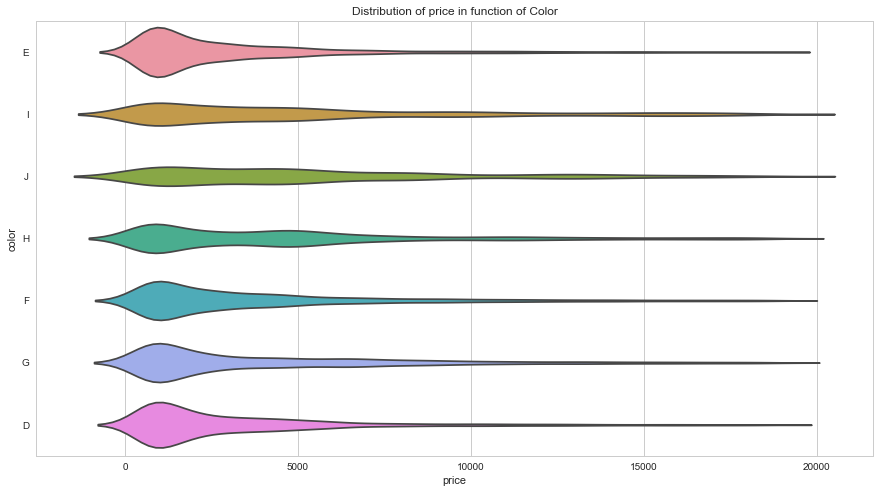

In [9]:
make_violin_plot("color")

## Modélisation

Après avoir mieux compris les données et savoir exploiter ces informations, il est temps de le mettre à profit.

In [10]:
X = df[["carat", "depth", "table", "x", "y", "z"]]
y = df["price"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)


from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

Définissons une fonction qui nous permettra de mesurer la performance d'une régression :

In [11]:
from sklearn.metrics import mean_squared_error, r2_score


def show_performance(y_true, y_pred):
    RMSE = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
    print("RMSE \t : %0.4f" % RMSE(y_true=y_true, y_pred=y_pred))
    print("R2 \t : %0.4f" % r2_score(y_true=y_true, y_pred=y_pred))

Voyons ce que cela donne sur notre exemple :

In [12]:
show_performance(y_test, y_pred)

RMSE 	 : 1489.8912
R2 	 : 0.8610


### Utilisation de la validation croisée

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


model = LinearRegression()
scores = cross_val_score(model, X_train, y_train, scoring=make_scorer(mean_squared_error), cv=10)

In [14]:
np.sqrt(scores)

array([1469.91857701, 1407.95427159, 2580.19461596, 1497.21567243,
       1508.52881549, 1563.41658411, 1488.98488561, 1500.98685377,
       1528.66993328, 1541.61692414])